In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [177]:
data = pd.read_csv('../data/regional_xgboost_data.csv')
enc = pd.read_csv('../data/regional_datasets/xgboost/enc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
esc = pd.read_csv('../data/regional_datasets/xgboost/esc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
midatl = pd.read_csv('../data/regional_datasets/xgboost/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
mount = pd.read_csv('../data/regional_datasets/xgboost/mountain_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
ne = pd.read_csv('../data/regional_datasets/xgboost/new_england_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
pac = pd.read_csv('../data/regional_datasets/xgboost/pacific_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
satl = pd.read_csv('../data/regional_datasets/xgboost/south_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wnc = pd.read_csv('../data/regional_datasets/xgboost/wnc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wsc = pd.read_csv('../data/regional_datasets/xgboost/wsc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')

East North Central
MASE:  0.3526985746033677
RMSE:  2471.2547585216694
MAE:  886.5801509372308
Train MASE:  2.13430265929578e-06
{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 500}
East South Central
MASE:  0.32804580725950183
RMSE:  1027.4771020626667
MAE:  494.0863989570926
Train MASE:  0.16478428351392194
{'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 300}
Mid-Atlantic
MASE:  0.5005937337248155
RMSE:  2564.687900543315
MAE:  1462.3689575195312
Train MASE:  0.30579745657545954
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}
Mountain
MASE:  0.5668594577535451
RMSE:  1478.959181103039
MAE:  577.6590428444409
Train MASE:  0.403027112915159
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 25}
New England
MASE:  0.3263142475595976
RMSE:  683.8908394300812
MAE:  304.0590292436779
Train MASE:  0.2689865994381676
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Pacific
MASE:  0.5388891157915424
RMSE:  6296.796616784494
MAE:  2909.9117477092336
Trai

<Figure size 1500x500 with 0 Axes>

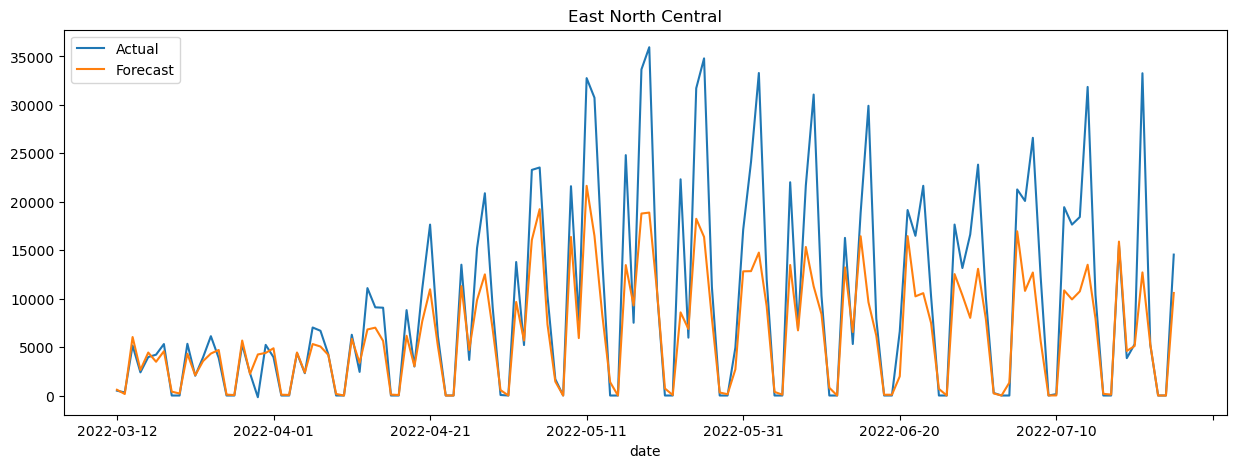

<Figure size 1500x500 with 0 Axes>

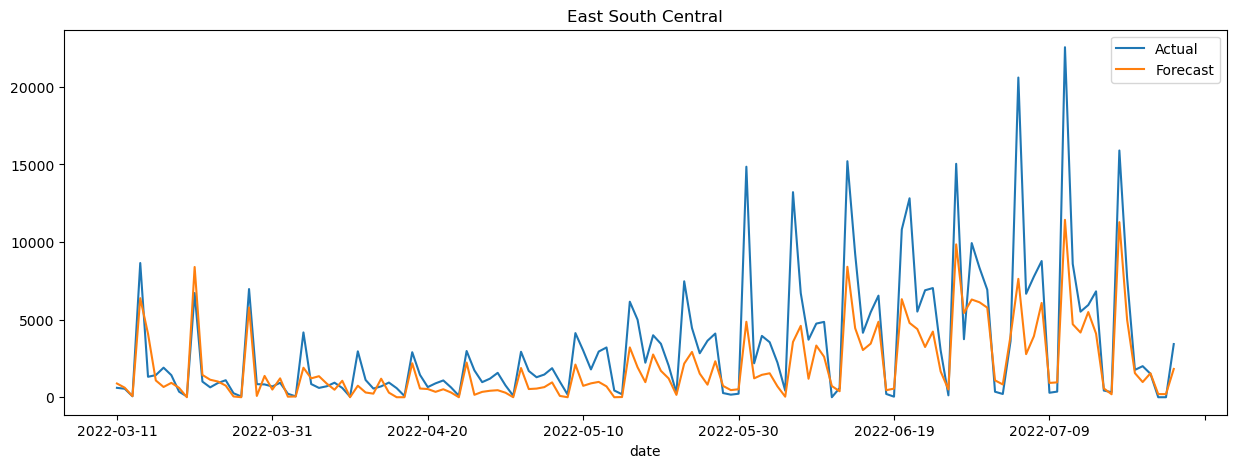

<Figure size 1500x500 with 0 Axes>

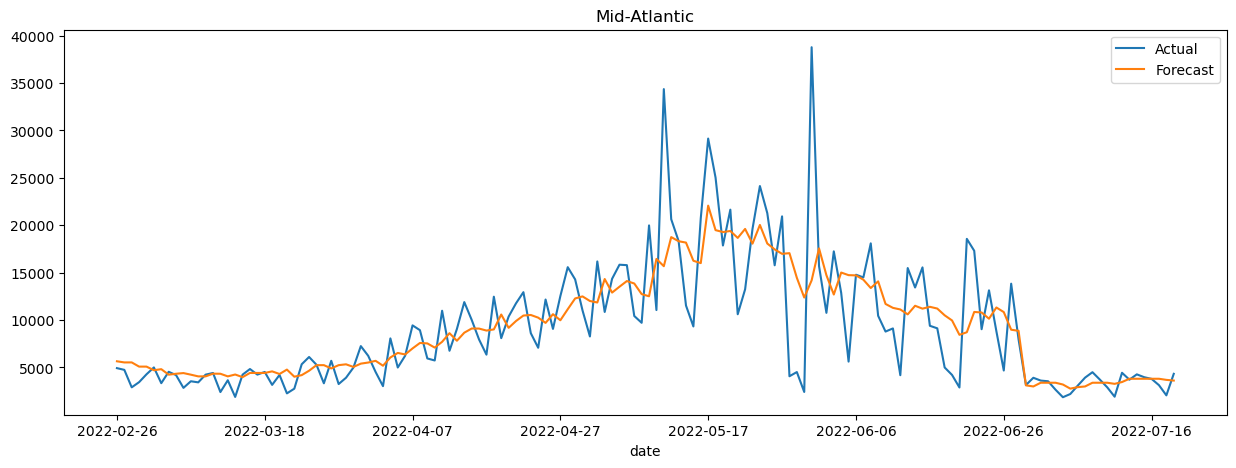

<Figure size 1500x500 with 0 Axes>

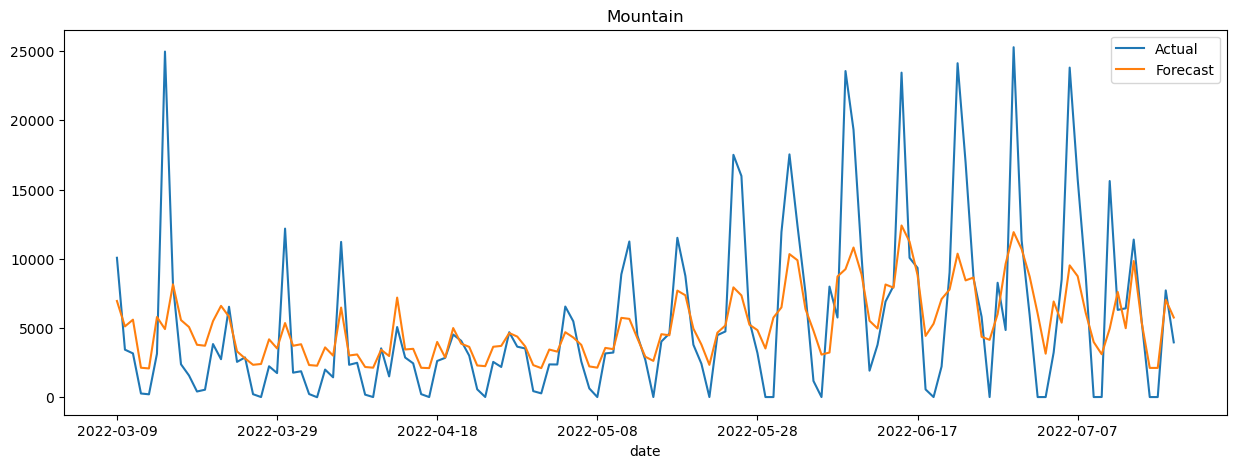

<Figure size 1500x500 with 0 Axes>

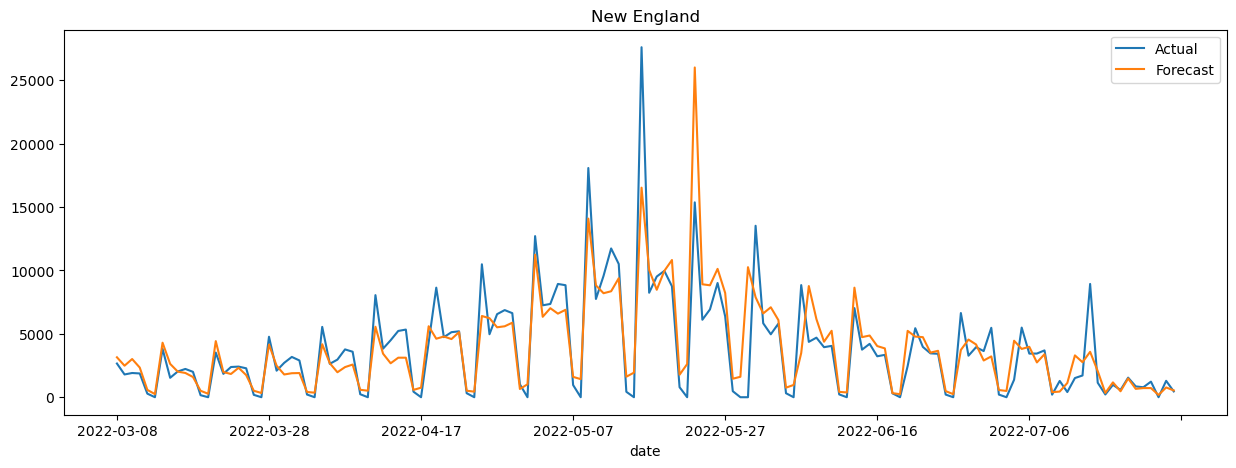

<Figure size 1500x500 with 0 Axes>

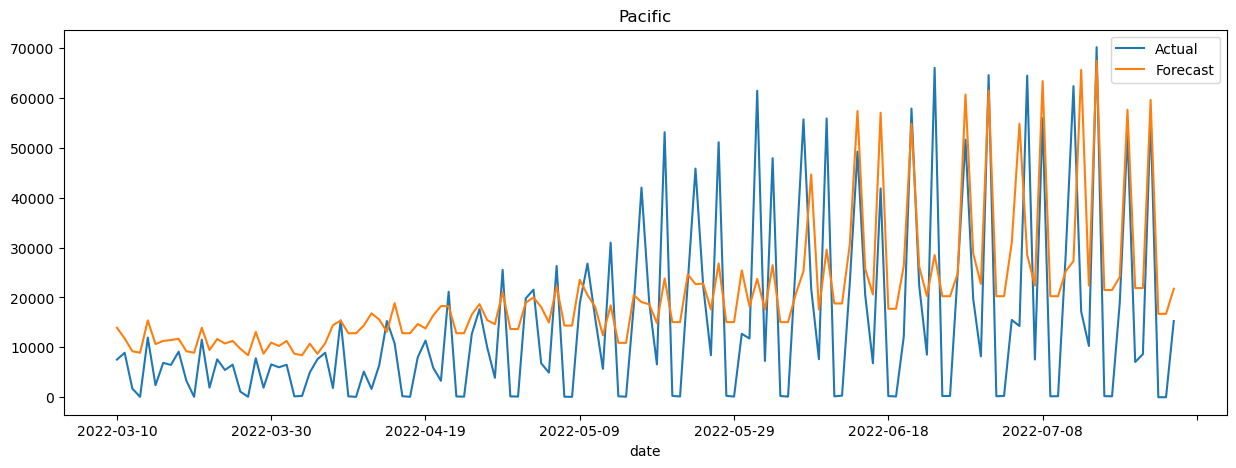

<Figure size 1500x500 with 0 Axes>

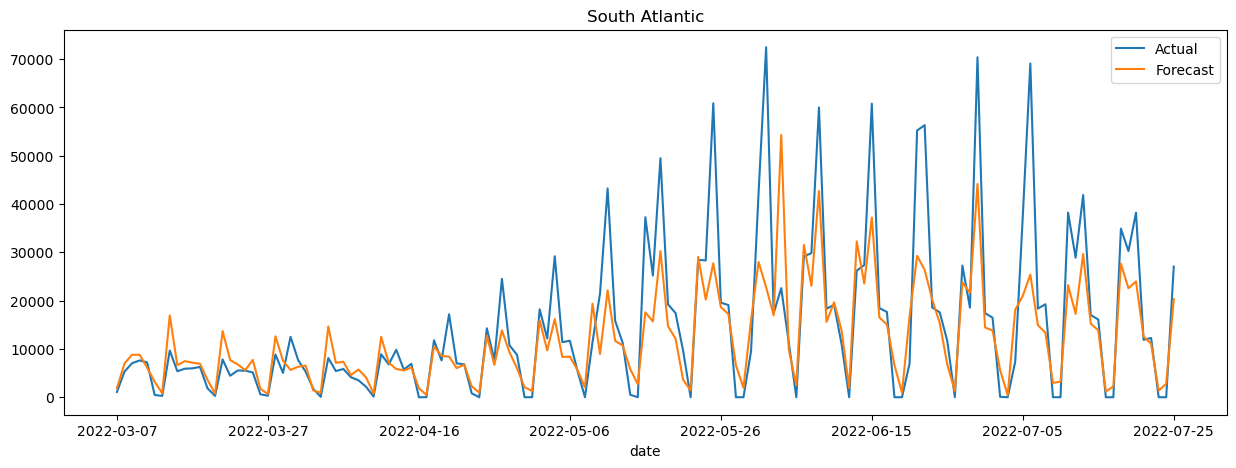

<Figure size 1500x500 with 0 Axes>

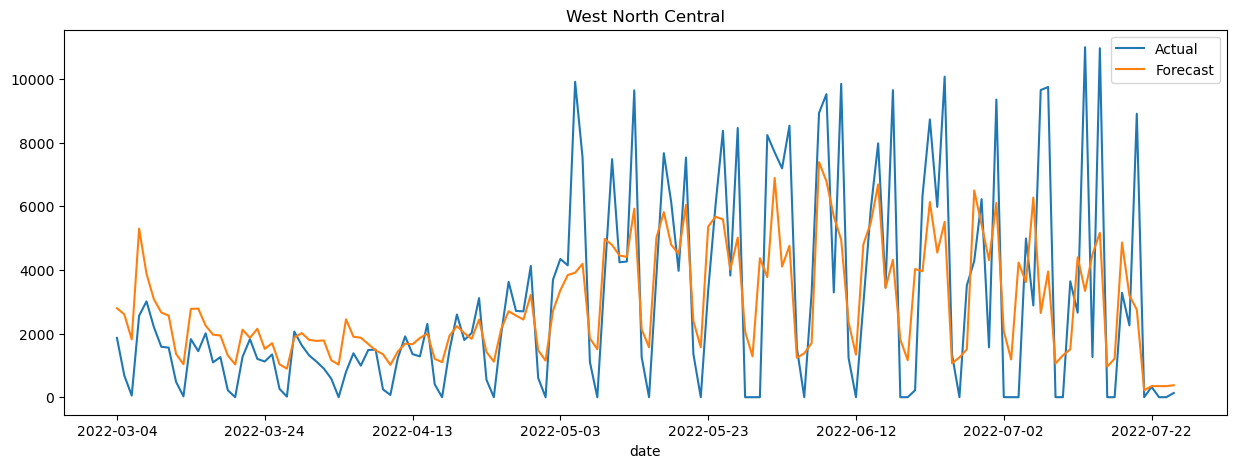

<Figure size 1500x500 with 0 Axes>

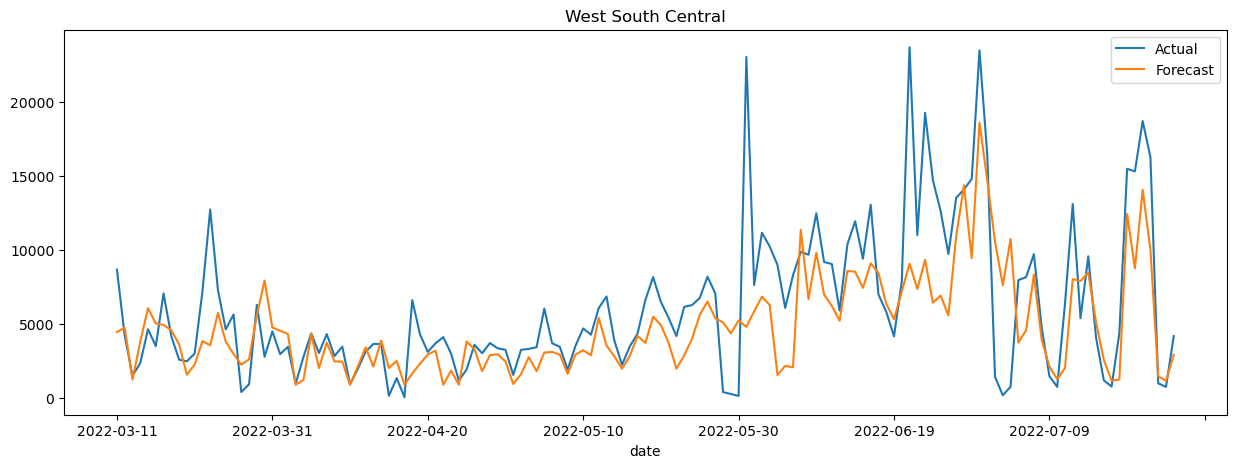

In [206]:
param_grid = {'n_estimators': [25, 50, 100, 300, 500],
              'learning_rate': [0.1, 0.15, 0.25, 0.3, 0.5],
              'max_depth': [2, 3, 5, 8]}
              # 'subsample': [0.5, 0.75, 1.0]}
predlist = dict()
paramlist = dict()
from sklearn.metrics import make_scorer
mas_error = make_scorer(mean_absolute_scaled_error)
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    print(data.region.unique()[0])
    data = data.sort_values(by=['date', 'location_key'])
    df = data.drop(columns = ['region', 'location_key'])
    # df['new_confirmed'] = df['new_confirmed'].replace(0, np.nan)
    # df['log_target'] = np.log(df.new_confirmed)
    # df.dropna(inplace = True)
    # df.drop(columns = ['new_confirmed'], inplace = True)
    model = xgb.XGBRegressor()
    y = df.new_confirmed
    X = df.drop(columns = ['new_confirmed'])
    size = round(data.shape[0]*0.15)
    model.fit(X, y)
    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X.columns)
    stats = stats.sort_values('importance', ascending=False)
    preds = stats[:10].index.tolist()
    X = df[preds]
    predlist[data.region.unique()[0]] = preds
    Xtrain = X.iloc[:-size]
    Xtest = X.iloc[-size:]
    ytrain = y.iloc[:-size]
    ytest = y.iloc[-size:]
    est = xgb.XGBRegressor()
    grid_result = GridSearchCV(estimator = est,
                        param_grid = param_grid,
                        cv = 5,
                        scoring = 'neg_root_mean_squared_error').fit(Xtrain, ytrain)
    model = xgb.XGBRegressor(n_estimators = grid_result.best_params_['n_estimators'],
                             learning_rate = grid_result.best_params_['learning_rate'],
                             max_depth = grid_result.best_params_['max_depth']).fit(Xtrain, ytrain)
    train_pred = model.predict(Xtrain)
    test_pred = model.predict(Xtest)
    test_pred = np.array([max(0, x) for x in test_pred])
    plt.figure(figsize = (15,5))
#     pd.concat([pd.concat([ytrain, ytest]).reset_index().new_confirmed, 
#            pd.DataFrame(np.concatenate((train_pred, test_pred)))[0]], axis = 1).plot(figsize = (15,5))
    # plt.plot(ytest.reset_index().drop(columns = 'date'))
    # plt.plot(test_pred)
    pd.DataFrame({'Actual': ytest, 'Forecast': test_pred}).groupby('date').sum().plot(figsize = (15,5))
    # plt.legend(['actual', 'forecast'])
#     plt.axvline(x = len(ytrain), color = 'green')
    plt.title(data.region.unique()[0])
    print('MASE: ', mean_absolute_scaled_error(ytest, test_pred, y_train = ytrain))
    print('RMSE: ', mean_squared_error(ytest, test_pred, squared = False))
    print('MAE: ', mean_absolute_error(ytest, test_pred))
    print('Train MASE: ', mean_absolute_scaled_error(ytrain, train_pred, y_train = ytrain))
    paramlist[data.region.unique()[0]] = grid_result.best_params_
    print(grid_result.best_params_)
    

In [199]:
preds + [x for x in enc.columns if x[:12] == 'location_key']

['7_day_avg',
 'cumulative_persons_fully_vaccinated',
 '7_day_shift',
 'workplace_closing',
 'cumulative_vaccine_doses_administered_moderna',
 'cumulative_deceased',
 'current_hospitalized_patients',
 'relative_humidity',
 'current_intensive_care_patients',
 'cumulative_confirmed',
 'location_key',
 'location_key_US_IL',
 'location_key_US_IN',
 'location_key_US_MI',
 'location_key_US_OH',
 'location_key_US_WI']

In [185]:
ytest

date
2022-03-11     486.0
2022-03-11    8159.0
2022-03-12     548.0
2022-03-12       0.0
2022-03-12     527.0
               ...  
2022-07-23     970.0
2022-07-23       0.0
2022-07-24     726.0
2022-07-24       0.0
2022-07-25    4158.0
Name: new_confirmed, Length: 519, dtype: float64

In [192]:
data

,region,location_key,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,...,year,month,day,location_key_US_AR,location_key_US_LA,location_key_US_OK,location_key_US_TX,1_day_shift,7_day_shift,7_day_avg
date,,,,,,,,,,,,,,,,,,,,,
2020-03-06,West South Central,US_AR,0.0,0.0,0.0,0.0,0.0,36168.3,293.1,114.7,...,2020.0,3.0,6.0,1,0,0,0,NaN,NaN,NaN
2020-03-07,West South Central,US_AR,0.0,0.0,0.0,0.0,0.0,31883.0,260.3,116.6,...,2020.0,3.0,7.0,1,0,0,0,0.0,NaN,NaN
2020-03-08,West South Central,US_AR,0.0,0.0,0.0,0.0,0.0,31728.9,230.6,126.3,...,2020.0,3.0,8.0,1,0,0,0,0.0,NaN,NaN
2020-03-09,West South Central,US_AR,0.0,0.0,0.0,0.0,0.0,31190.5,162.3,167.3,...,2020.0,3.0,9.0,1,0,0,0,0.0,NaN,NaN
2020-03-10,West South Central,US_AR,0.0,0.0,0.0,0.0,0.0,32361.3,150.1,183.5,...,2020.0,3.0,10.0,1,0,0,0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-04,West South Central,US_TX,350.0,0.0,7118682.0,88923.0,474.0,524285.0,2682.0,365.0,...,2022.0,7.0,4.0,0,0,0,1,0.0,9840.0,6758.571429
2022-07-19,West South Central,US_TX,10191.0,27.0,7321472.0,89201.0,712.0,533759.0,3568.0,511.0,...,2022.0,7.0,19.0,0,0,0,1,350.0,10238.0,6751.857143
2022-07-20,West South Central,US_TX,13447.0,8.0,7334919.0,89209.0,673.0,534432.0,3485.0,507.0,...,2022.0,7.0,20.0,0,0,0,1,10191.0,10419.0,7184.428571


In [170]:
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    

{'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 50}

East North Central
MASE:  0.6076679814645186
RMSE:  2854.447769883381
MAE:  1527.4980096882737
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
East South Central
MASE:  0.3460048897749992
RMSE:  1106.219177197354
MAE:  521.1354823847497
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
Mid-Atlantic
MASE:  0.5118723008625461
RMSE:  2611.612778941004
MAE:  1495.3166860993376
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
Mountain
MASE:  0.6097616221079378
RMSE:  1432.8401318410004
MAE:  621.3785624853892
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
New England
MASE:  0.3599874435396986
RMSE:  724.733870900652
MAE:  335.43565272185333
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
Pacific
MASE:  0.7532480984990723
RMSE:  9125.448416409014
MAE:  4067.414661998807
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample'

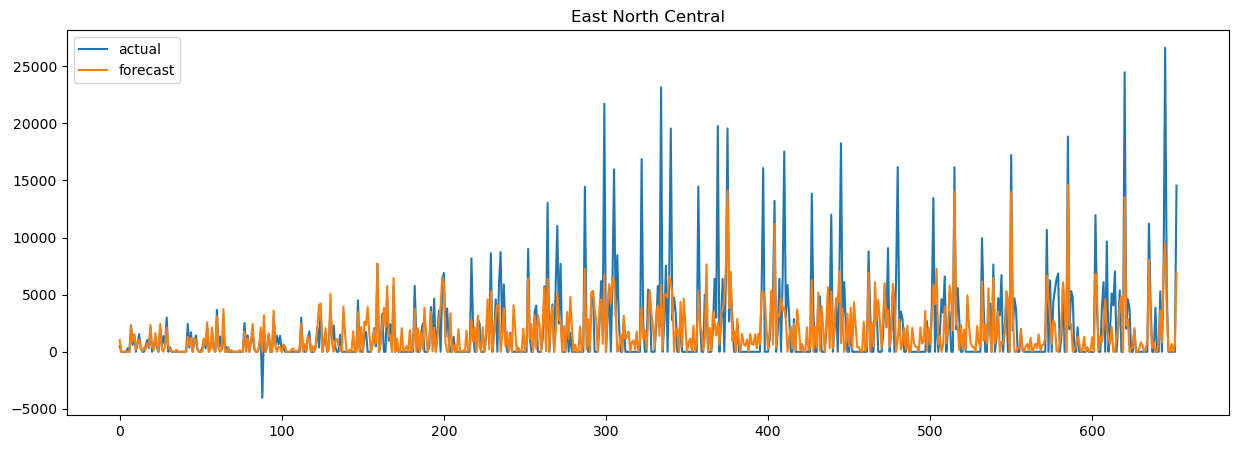

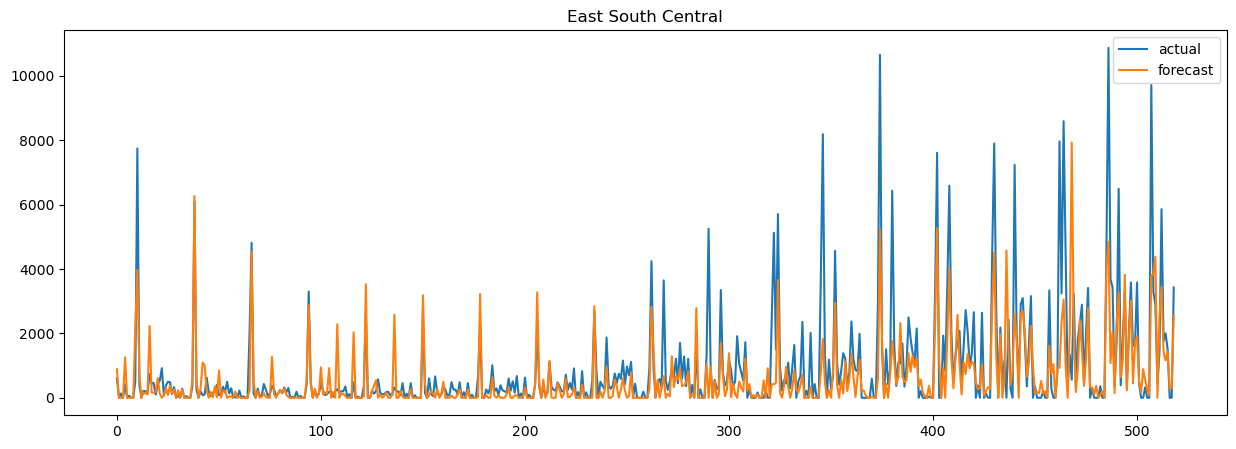

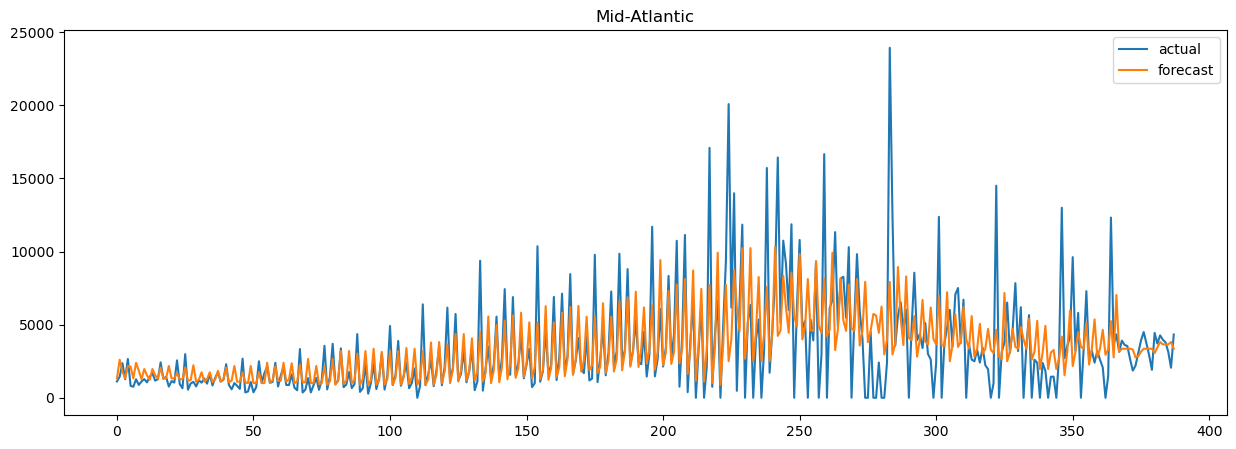

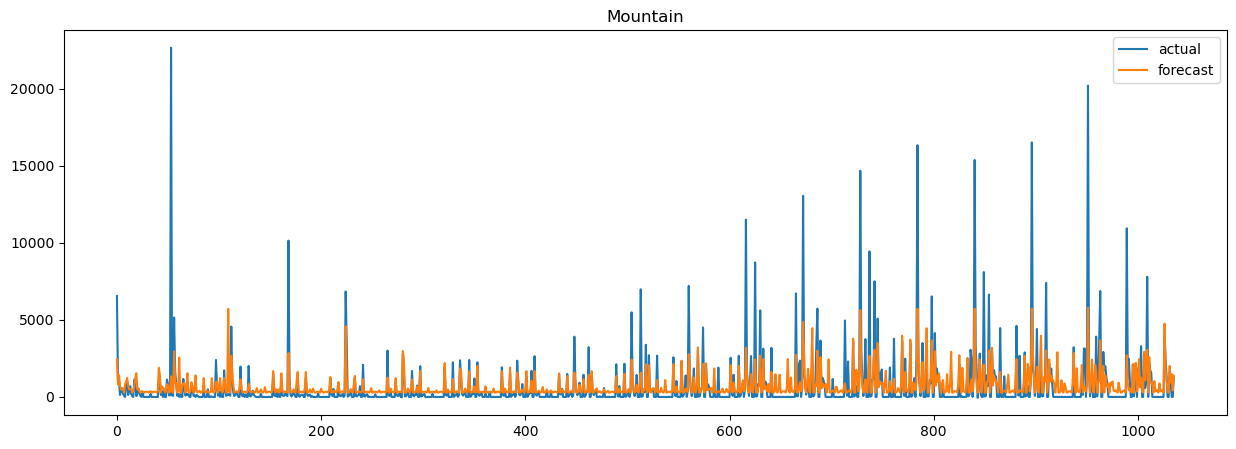

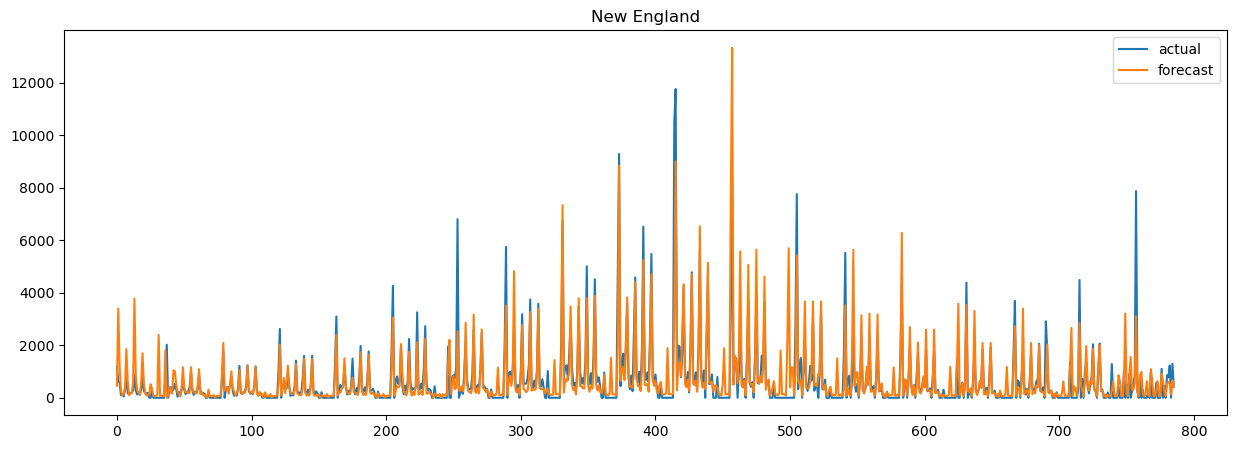

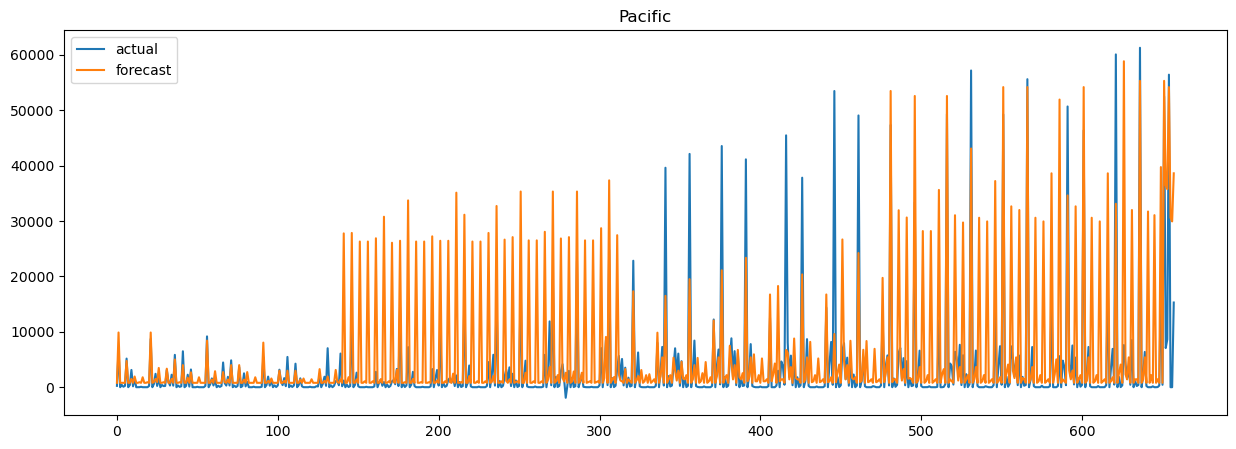

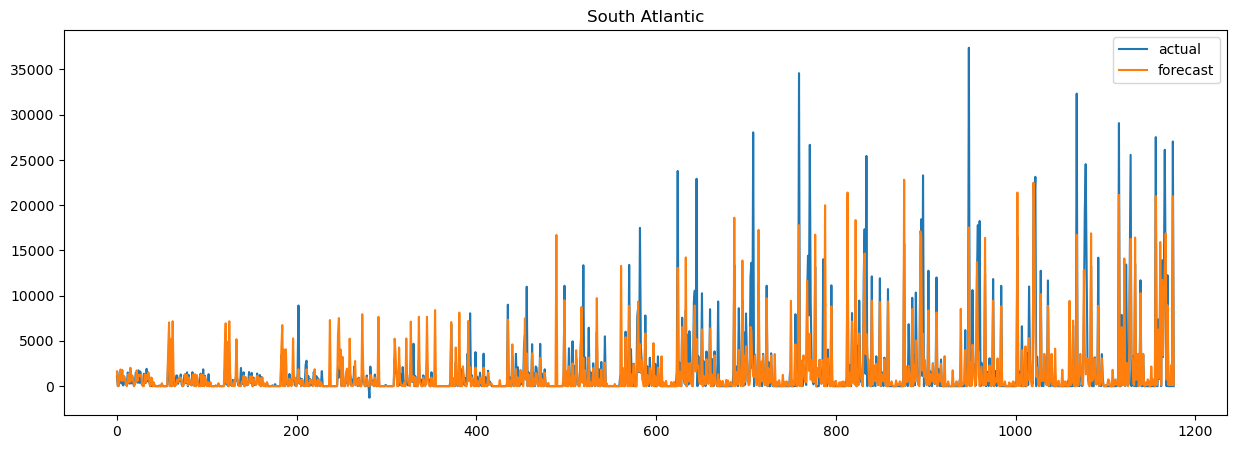

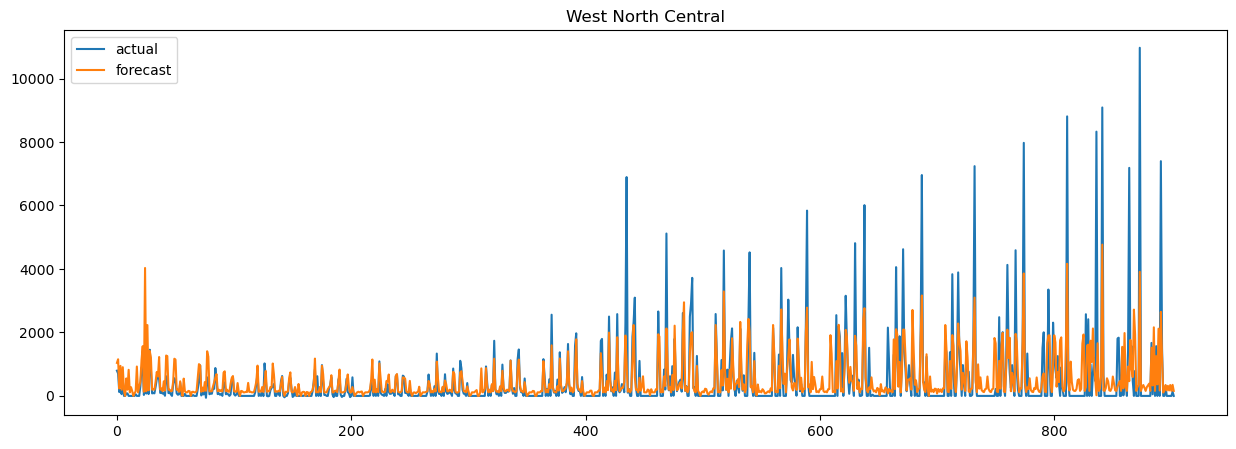

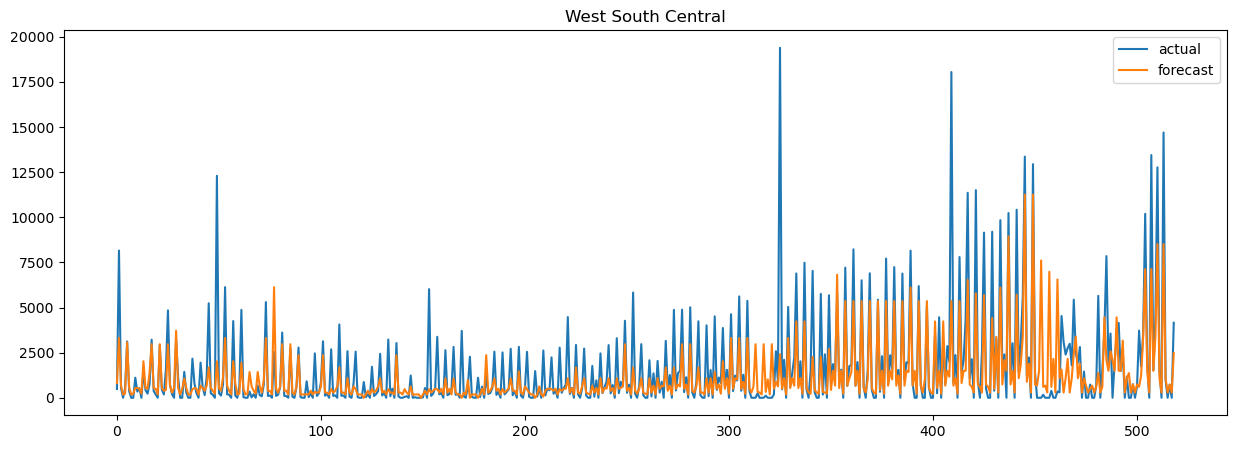

In [173]:
param_grid = {
    # 'n_estimators': [25, 50, 100, 300, 500],
    # 'learning_rate': [0.1, 0.15, 0.25, 0.3, 0.5],
    # 'max_depth': [2, 3, 5, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}
from sklearn.metrics import make_scorer
mas_error = make_scorer(mean_absolute_scaled_error)
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    print(data.region.unique()[0])
    data = data.sort_values(by=['date', 'location_key'])
    df = data.drop(columns = ['region', 'location_key'])
    # df['new_confirmed'] = df['new_confirmed'].replace(0, np.nan)
    # df['log_target'] = np.log(df.new_confirmed)
    # df.dropna(inplace = True)
    # df.drop(columns = ['new_confirmed'], inplace = True)
    model = xgb.XGBRegressor()
    y = df.new_confirmed
    X = df.drop(columns = ['new_confirmed'])
    size = round(data.shape[0]*0.15)
    model.fit(X, y)
    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X.columns)
    stats = stats.sort_values('importance', ascending=False)
    preds = stats[:10].index.tolist()
    X = df[preds]
    Xtrain = X.iloc[:-size]
    Xtest = X.iloc[-size:]
    ytrain = y.iloc[:-size]
    ytest = y.iloc[-size:]
    est = xgb.XGBRegressor()
    grid_result = GridSearchCV(estimator = est,
                        param_grid = param_grid,
                        cv = 5,
                        scoring = mas_error).fit(Xtrain, ytrain)
    model = xgb.XGBRegressor(
    n_estimators=paramlist[data.region.unique()[0]]['n_estimators'],
    learning_rate=paramlist[data.region.unique()[0]]['learning_rate'],
    max_depth=paramlist[data.region.unique()[0]]['max_depth'],
    subsample=grid_result.best_params_.get('subsample', 1.0), # Providing a default value if not set by grid search
    colsample_bytree=grid_result.best_params_.get('colsample_bytree', 1.0), # Providing a default value
    min_child_weight=grid_result.best_params_.get('min_child_weight', 1), # Providing a default value
    gamma=grid_result.best_params_.get('gamma', 0) # Providing a default value
).fit(Xtrain, ytrain)
    train_pred = model.predict(Xtrain)
    test_pred = model.predict(Xtest)
    test_pred = np.array([max(0, x) for x in test_pred])
    plt.figure(figsize = (15,5))
#     pd.concat([pd.concat([ytrain, ytest]).reset_index().new_confirmed, 
#            pd.DataFrame(np.concatenate((train_pred, test_pred)))[0]], axis = 1).plot(figsize = (15,5))
    plt.plot(ytest.reset_index().drop(columns = 'date'))
    plt.plot(test_pred)
    plt.legend(['actual', 'forecast'])
#     plt.axvline(x = len(ytrain), color = 'green')
    plt.title(data.region.unique()[0])
    print('MASE: ', mean_absolute_scaled_error(ytest, test_pred, y_train = ytrain))
    print('RMSE: ', mean_squared_error(ytest, test_pred, squared = False))
    print('MAE: ', mean_absolute_error(ytest, test_pred))
    print(grid_result.best_params_)
    

{'East North Central': ['7_day_shift',
  '7_day_avg',
  '1_day_shift',
  'contact_tracing',
  'new_deceased',
  'new_vaccine_doses_administered_moderna',
  'cumulative_vaccine_doses_administered_moderna',
  'international_travel_controls',
  'cumulative_deceased',
  'current_hospitalized_patients'],
 'East South Central': ['7_day_shift',
  '7_day_avg',
  '1_day_shift',
  'location_key_US_AL',
  'cumulative_vaccine_doses_administered_moderna',
  'new_deceased',
  'facial_coverings',
  'restrictions_on_gatherings',
  'new_persons_fully_vaccinated',
  'month'],
 'Mid-Atlantic': ['7_day_avg',
  'contact_tracing',
  'cumulative_hospitalized_patients',
  'cumulative_persons_vaccinated',
  'new_persons_vaccinated',
  '2_day_shift',
  '1_day_shift',
  '8_day_shift',
  'current_intensive_care_patients',
  'cumulative_confirmed'],
 'Mountain': ['7_day_shift',
  '7_day_avg',
  'cumulative_vaccine_doses_administered_janssen',
  'public_transport_closing',
  'cancel_public_events',
  '1_day_shift',

<Axes: >

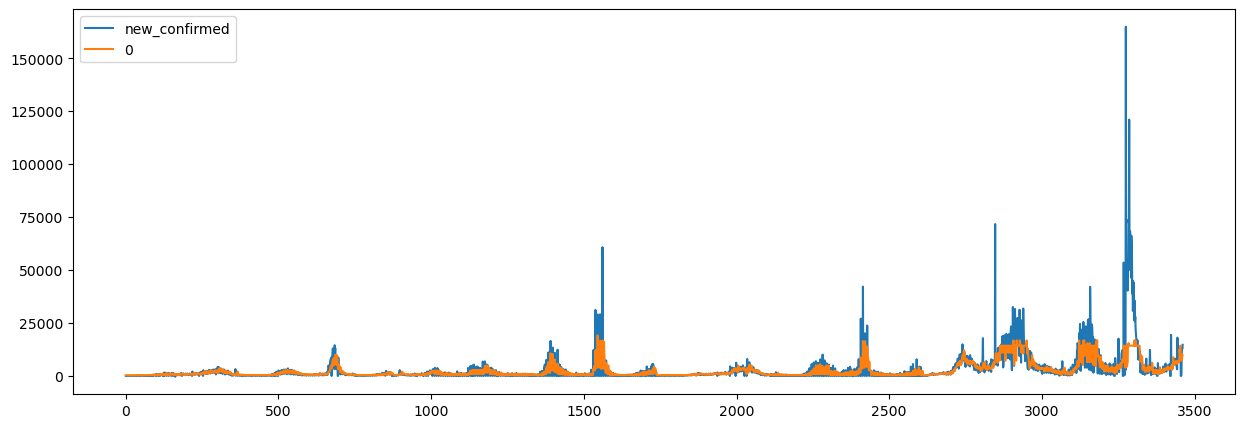

In [89]:
pd.concat([pd.concat([ytrain, ytest]).reset_index().new_confirmed, 
           pd.DataFrame(np.concatenate((train_pred, test_pred)))[0]], axis = 1).plot(figsize = (15,5))

In [111]:
np.array([max(0, x) for x in test_pred])

array([1.51354072e+04, 1.51516133e+04, 3.54370430e+04, 9.75363672e+03,
       1.38576787e+04, 3.30135645e+03, 0.00000000e+00, 5.58119125e+01,
       1.29530557e+04, 9.02719955e+01, 3.63726807e+03, 1.72507217e+02,
       3.27227509e+02, 1.15354111e+04, 1.50856400e+02, 3.90373828e+04,
       3.93314570e+04, 3.87457812e+04, 1.16054707e+04, 1.85438809e+04,
       1.36685947e+04, 1.09020586e+04, 1.28198538e+01, 1.67421914e+04,
       8.76409082e+03, 1.47277109e+04, 1.09158184e+04, 3.54604805e+04,
       1.48264678e+04, 9.59929102e+03, 1.02514326e+04, 1.00396631e+04,
       3.72160352e+03, 6.14444922e+03, 1.03214941e+04, 1.29786299e+04,
       1.67652246e+04, 2.37400137e+04, 2.02872441e+04, 8.99981348e+03,
       3.80998462e+03, 1.84676880e+02, 3.79553076e+03, 1.07043770e+04,
       0.00000000e+00, 3.85667310e+03, 1.18637161e+02, 3.92050562e+03,
       5.85211768e+03, 9.50659027e+01, 2.76155391e+04, 1.24777354e+04,
       2.14483867e+04, 4.04360596e+03, 9.63602441e+03, 1.28568555e+04,
      

In [71]:
pd.concat([ytrain, ytest])

date
2020-03-06        0.0
2020-03-07        0.0
2020-03-08        0.0
2020-03-09        0.0
2020-03-10        0.0
               ...   
2022-07-04      350.0
2022-07-19    10191.0
2022-07-20    13447.0
2022-07-21    12768.0
2022-07-22    14695.0
Name: new_confirmed, Length: 3462, dtype: float64

In [36]:
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    print(data.region.unique()[0])
    df = data.drop(columns = ['region', 'location_key'])
    df.dropna(inplace = True)
    model = xgb.XGBRegressor()
    y = df.new_confirmed
    X = df.drop(columns = ['new_confirmed'])
    model.fit(X, y)
    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X.columns)
    stats = stats.sort_values('importance', ascending=False)

East North Central
East South Central
Mid-Atlantic
Mountain
New England
Pacific
South Atlantic
West North Central
West South Central


In [37]:
stats

,importance
7_day_avg,0.436162
cumulative_persons_fully_vaccinated,0.122251
7_day_shift,0.117236
workplace_closing,0.058774
cumulative_deceased,0.053433
...,...
location_key_US_SD,0.000000
location_key_US_NJ,0.000000
year,0.000000
cumulative_vaccine_doses_administered_pfizer,0.000000


In [183]:
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    print(data.shape)

(4355, 62)
(3461, 62)
(2586, 61)
(6908, 65)
(5237, 62)
(4387, 63)
(7848, 66)
(6018, 64)
(3462, 60)
